In [1]:
%reload_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import csv

sys.path.append(os.path.join(os.getcwd(), os.pardir))
from plot import colorPanel, loader, stick
from plot.cd import cd
import glob
import json
#from plotting import cd
#from plotting import baseline_logger as bl

%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

In [2]:
def smooth_reward_curve(x, y):
    print (len(x))
    halfwidth = min(151, int(np.ceil(len(x)/15))) # Halfwidth of our smoothing convolution
    k = halfwidth
    xsmoo = x[k:-k]
    ysmoo = np.convolve(y, np.ones(2*k+1), mode='valid') / np.convolve(np.ones_like(y), np.ones(2*k+1), mode='valid')
    downsample = max(int(np.floor(len(xsmoo)/1e3)),1)
    return xsmoo[::downsample], ysmoo[::downsample]

def process_json(path):
    with open(path, 'r') as f:
        r = {'l': [], 'r': []}
        ccnt = 0
        kk = 0
        tmp = []
        ff = 0
        lines = csv.reader(f)
        for line in lines:
            if ff < 2:
                ff += 1
                continue
#             d = json.loads(line)
#             kk += d['TimestepsSoFar']
            kk += int(line[1])
            tmp.append(float(line[0]))
#             tmp.append(d['r'][0])
            if kk >= 1000:
                ccnt += 1
                r['l'].append(ccnt*1000)
                kk = kk % 1000
                r['r'].append(np.mean(tmp))
                tmp = []
#             if ccnt == 20000:
#                 break
    for k in ['l', 'r']:
        r[k] = np.array(r[k])
    return r


def average_dict(res, keys):
    """
    :param res: the dict
    :param keys: keys
    :return: a dict with (key, (mean, std)) of results.
    """
    ret = dict()
    for k in keys:
        vs = [r[k] for r in res]
        l = min(v.shape[0] for v in vs)
        vs = [v[np.newaxis, :l] for v in vs]
        vs = np.concatenate(vs, axis=0)
#         if k == 'r':
#             vs = (vs-rr)/(er-rr)
        m, s = np.median(vs, axis=0), np.std(vs, axis=0, dtype=np.float64)
        ret[k] = [m, s]
    return ret

In [13]:
def get_data(prefix, criterion, d_type):
    trpo_filter = ['seed-/']
    acktr_filter = ['seed-/']
    with cd(prefix):
        paths = glob.glob(criterion)
        d = dict()
        print (paths, criterion)
        for path in paths:
            files = glob.glob(path + '/seed-*/0.monitor.csv')
#             if d_type == 'trpo':
#                 files = [path+'/seed-2/0.monitor.csv', path+'/seed-6/0.monitor.csv', path+'/seed-5/0.monitor.csv']
#             elif d_type == 'acktr':
#                 files = [path+'/seed-0/0.monitor.csv', path+'/seed-3/0.monitor.csv', path+'/seed-2/0.monitor.csv']
#             else:
#                 assert False, "Not implemented"
            res = []
            for f in files:
#                 if 'seed-14/' in f or 'seed-1/' in f or 'seed-6/' in f:
#                     continue
                print (f)
                r = process_json(f)
                res.append(r)
            print (len(res))
            if True:
                res = average_dict(res, ['l', 'r'])
            d[path] = res
        #print (path)        
#         print ("len is %d"%(len(paths)))
#         for k, v in d.items():
#             print (k)
#         abc
        if len(paths) == 1:
            for k, v in d.items():
                return v
        else:
            return d

In [14]:
def plotArg(game, ax):
    env_id, traj_need = game.split('-')
    colors = colorPanel.colorPanel(1).getColors()
    d_type = ['acktr', 'trpo']#, 'centralized']
    cnt = 0
    
    for i in range(len(d_type)):
        for j in range(1):
            datas = get_data(prefix='/atlas/u/hyren/multiagent/nipsrebuttal/baselines/exps/', 
                              criterion='%s/%s/'%(d_type[i], game), d_type=d_type[i])
            print ('GET!: %s/%s/'%(d_type[i],game))
            label = '%s' % (d_type[i])
            x = datas['l']
            y = datas['r']
            x = x[0]
            y_mean = y[0]
            y_std = y[1]
            xx = x
            x, y_mean = smooth_reward_curve(xx, y_mean)
            x, y_std = smooth_reward_curve(xx, y_std)
            x = x * 1e7 / np.max(x)
            cnt += 1
#             color = colors[cnt]
            
            if i > 0:
                color = colors[4]
            else:    
                color = colors[i]    
            y_upper = y_mean + y_std
            y_lower = y_mean - y_std
            ax.fill_between(
                x, list(y_lower), list(y_upper), interpolate=True, facecolor=color, linewidth=0.0, alpha=0.3
            )
            line = ax.plot(x, list(y_mean), label=label, color=color, rasterized=True)          

    game = 'Hopper'
    stick.cutsomStick(game, 'timesteps', ax)
    if args == 'Reacher-v1':
        ax.set_ylim(-30, 0)
    #ax.set_ylim(-70,0)

Hopper-v1
(['acktr/Hopper-v1/'], 'acktr/Hopper-v1/')
acktr/Hopper-v1/seed-2/0.monitor.csv
acktr/Hopper-v1/seed-1/0.monitor.csv
acktr/Hopper-v1/seed-3/0.monitor.csv
acktr/Hopper-v1/seed-4/0.monitor.csv
acktr/Hopper-v1/seed-0/0.monitor.csv
5
GET!: acktr/Hopper-v1/
10000
10000
(['trpo/Hopper-v1/'], 'trpo/Hopper-v1/')
trpo/Hopper-v1/seed-3/0.monitor.csv
trpo/Hopper-v1/seed-4/0.monitor.csv
trpo/Hopper-v1/seed-0/0.monitor.csv
trpo/Hopper-v1/seed-5/0.monitor.csv
trpo/Hopper-v1/seed-2/0.monitor.csv
trpo/Hopper-v1/seed-6/0.monitor.csv
trpo/Hopper-v1/seed-1/0.monitor.csv
7
GET!: trpo/Hopper-v1/
10000
10000


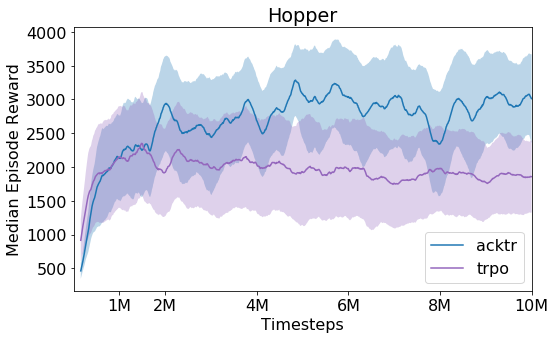

In [15]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
columns = 1
sixAtariGames = [
    'Hopper-v1',
]

for i, args in enumerate(sixAtariGames):
    print(args)
    #ax = fig.add_subplot(len(sixAtariGames) / columns + 1, columns, i + 1)
    #ax = fig.add_subplot(1, 1, 1)
    plotArg(args, ax)

plt.legend(loc=4)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Median Episode Reward')

fig.tight_layout()
# fig.savefig('reacher.pdf', dpi=1000, bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig('hopper-all.pdf', dpi=300)